In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import pmdarima as pm
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('./data/processed_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [4]:
feature = 'total load actual'
y = data.rolling(24*7, center=True).mean()[feature].dropna()

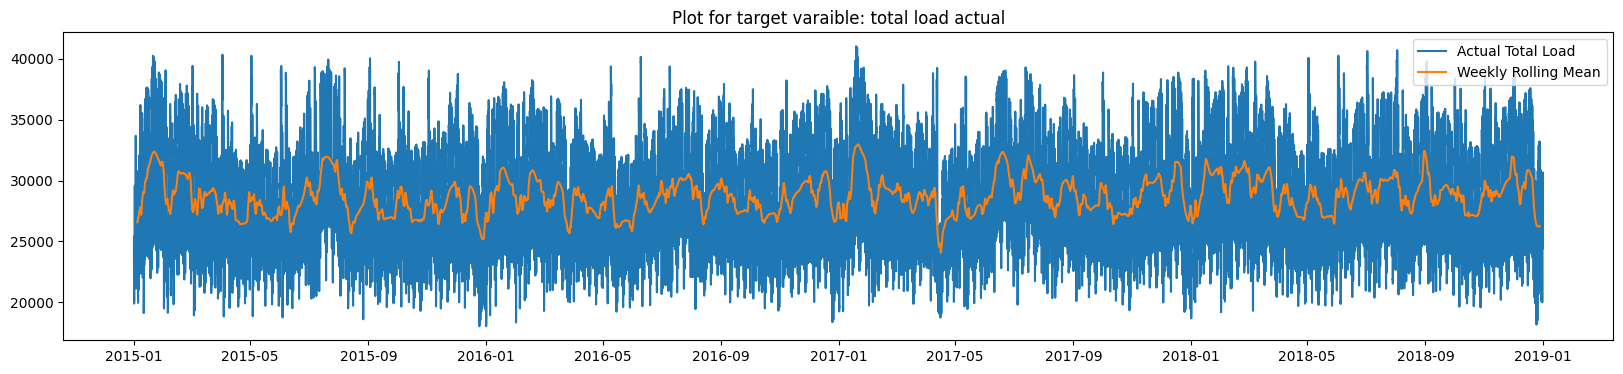

In [5]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(data[feature])
ax.plot(y)
ax.set_title("Plot for target varaible: "+feature)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend(['Actual Total Load', 'Weekly Rolling Mean'])
plt.show()

## Stationary Tests

### For the raw data

In [5]:
y = data['total load actual']

In [6]:
result_diff = adfuller(y)
print(f"ADF Statistic of the raw data: {result_diff[0]:.4f}, p-value: {result_diff[1]:.4f}")

ADF Statistic of the raw data: -21.4339, p-value: 0.0000


Since p-value <= 0.05, ADF reject H0 and the data is likely stationary

In [7]:
stat, p_value, lags, crit = kpss(y, regression='c')

print("KPSS Statistic :", stat)
print("p-value        :", p_value)
print("lags used      :", lags)
print("critical value :", crit)

KPSS Statistic : 0.8708093229455381
p-value        : 0.01
lags used      : 70
critical value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_83377/1010370939.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(y, regression='c')


Since p-value <=> 0.05, KPSS reject H0 and the data is not likely stationary

The results from ADF and KPSS do not match and we would like to perfrom differencing on the raw data

### For the 1st differencing data:

In [8]:
diff = data['total load actual'].diff().dropna()

### Augmented Dickey-Fuller (ADF) test

In [9]:
result_diff = adfuller(diff)
print(f"ADF Statistic after 1st diff: {result_diff[0]:.4f}, p-value: {result_diff[1]:.4f}")

ADF Statistic after 1st diff: -34.2917, p-value: 0.0000


Since p-value <= 0.05, ADF reject H0 and the data is likely stationary

### KPSS Test

In [10]:
diff = data['total load actual'].diff().dropna()
stat, p_value, lags, crit = kpss(diff, regression='c')

print("KPSS Statistic :", stat)
print("p-value        :", p_value)
print("lags used      :", lags)
print("critical value :", crit)

KPSS Statistic : 0.02562935109780075
p-value        : 0.1
lags used      : 1431
critical value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_83377/943923991.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, lags, crit = kpss(diff, regression='c')


Since p-value > 0.05, KPSS fail to reject H0 and the data is likely stationary

Both tests show the data is stationary after 1st differencing and the energy consumption data is suitable for ARIMA.

### ACF and PACF Plot

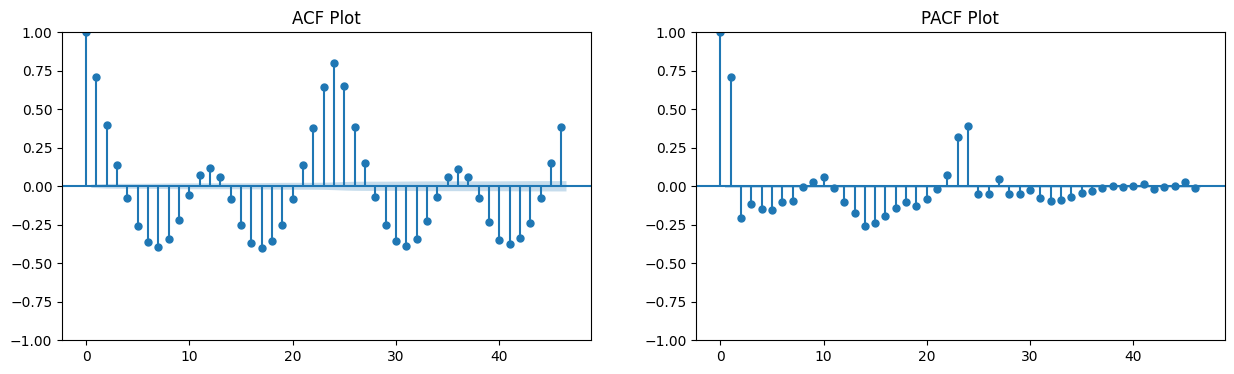

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
plot_acf(diff, ax=axes[0])
axes[0].set_title("ACF Plot")
plot_pacf(diff, ax=axes[1])
axes[1].set_title("PACF Plot")
plt.show()

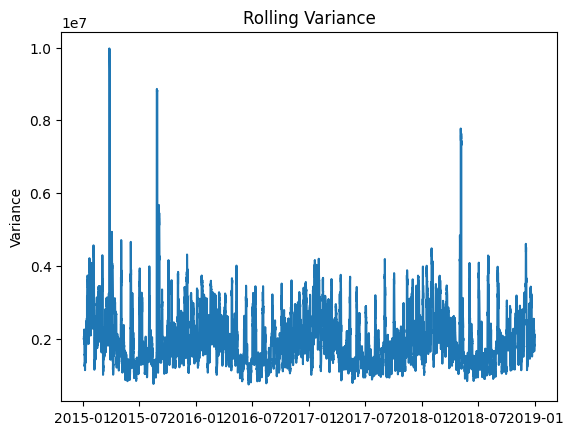

In [12]:
rolling_var = diff.rolling(48).var()   # choose window ~ seasonal period
plt.plot(rolling_var)
plt.title("Rolling Variance")
plt.ylabel("Variance")
plt.show()

It shows that there is a few outliers in the rolling variance

## Seasonal Decomposition Test

For all data

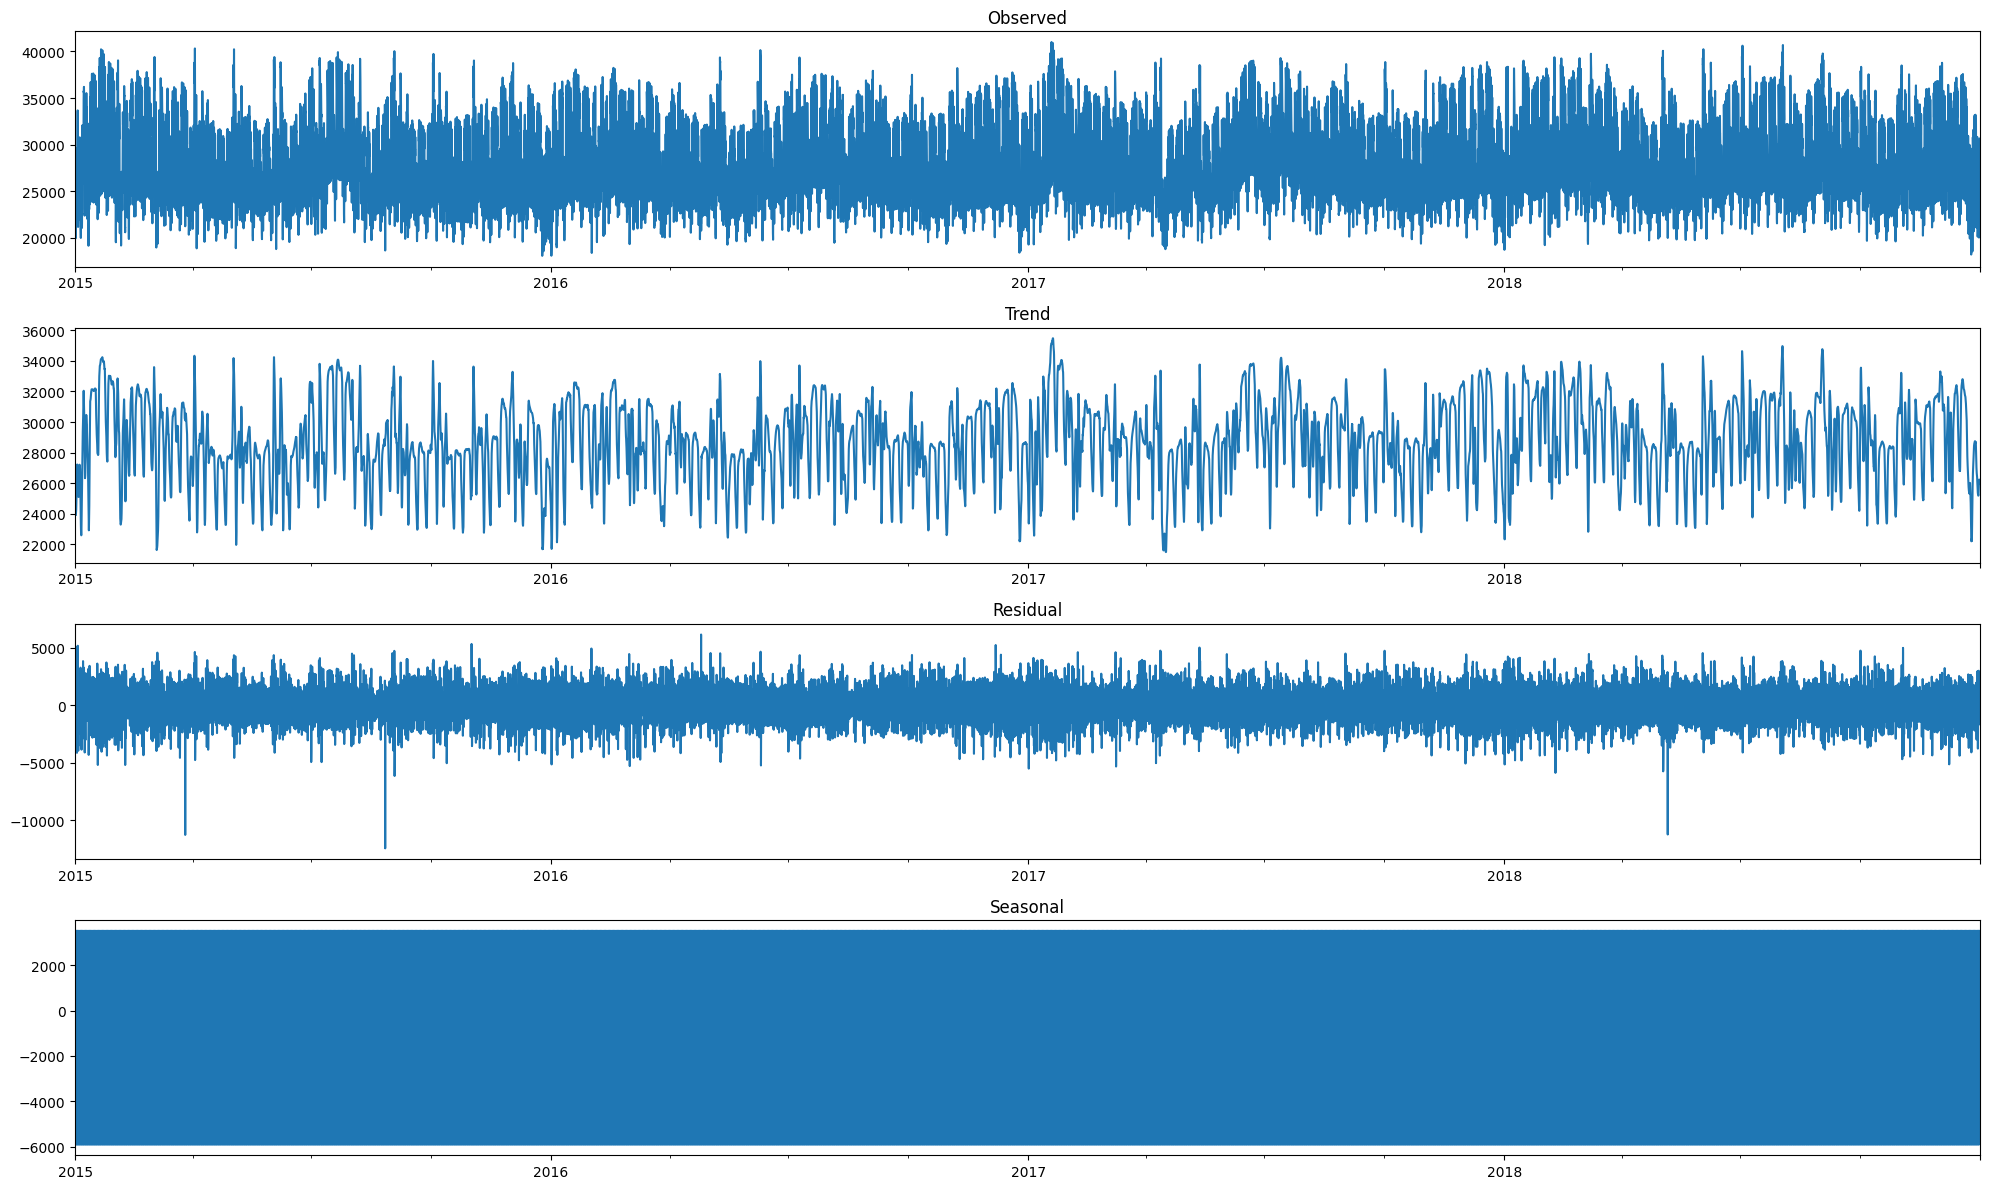

In [13]:
decompose_result = sm.tsa.seasonal_decompose(data[feature], model='additive', period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
decompose_result.observed.plot(ax=ax1, title='Observed')
decompose_result.trend.plot(ax=ax2, title='Trend')
decompose_result.resid.plot(ax=ax3, title='Residual')
decompose_result.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

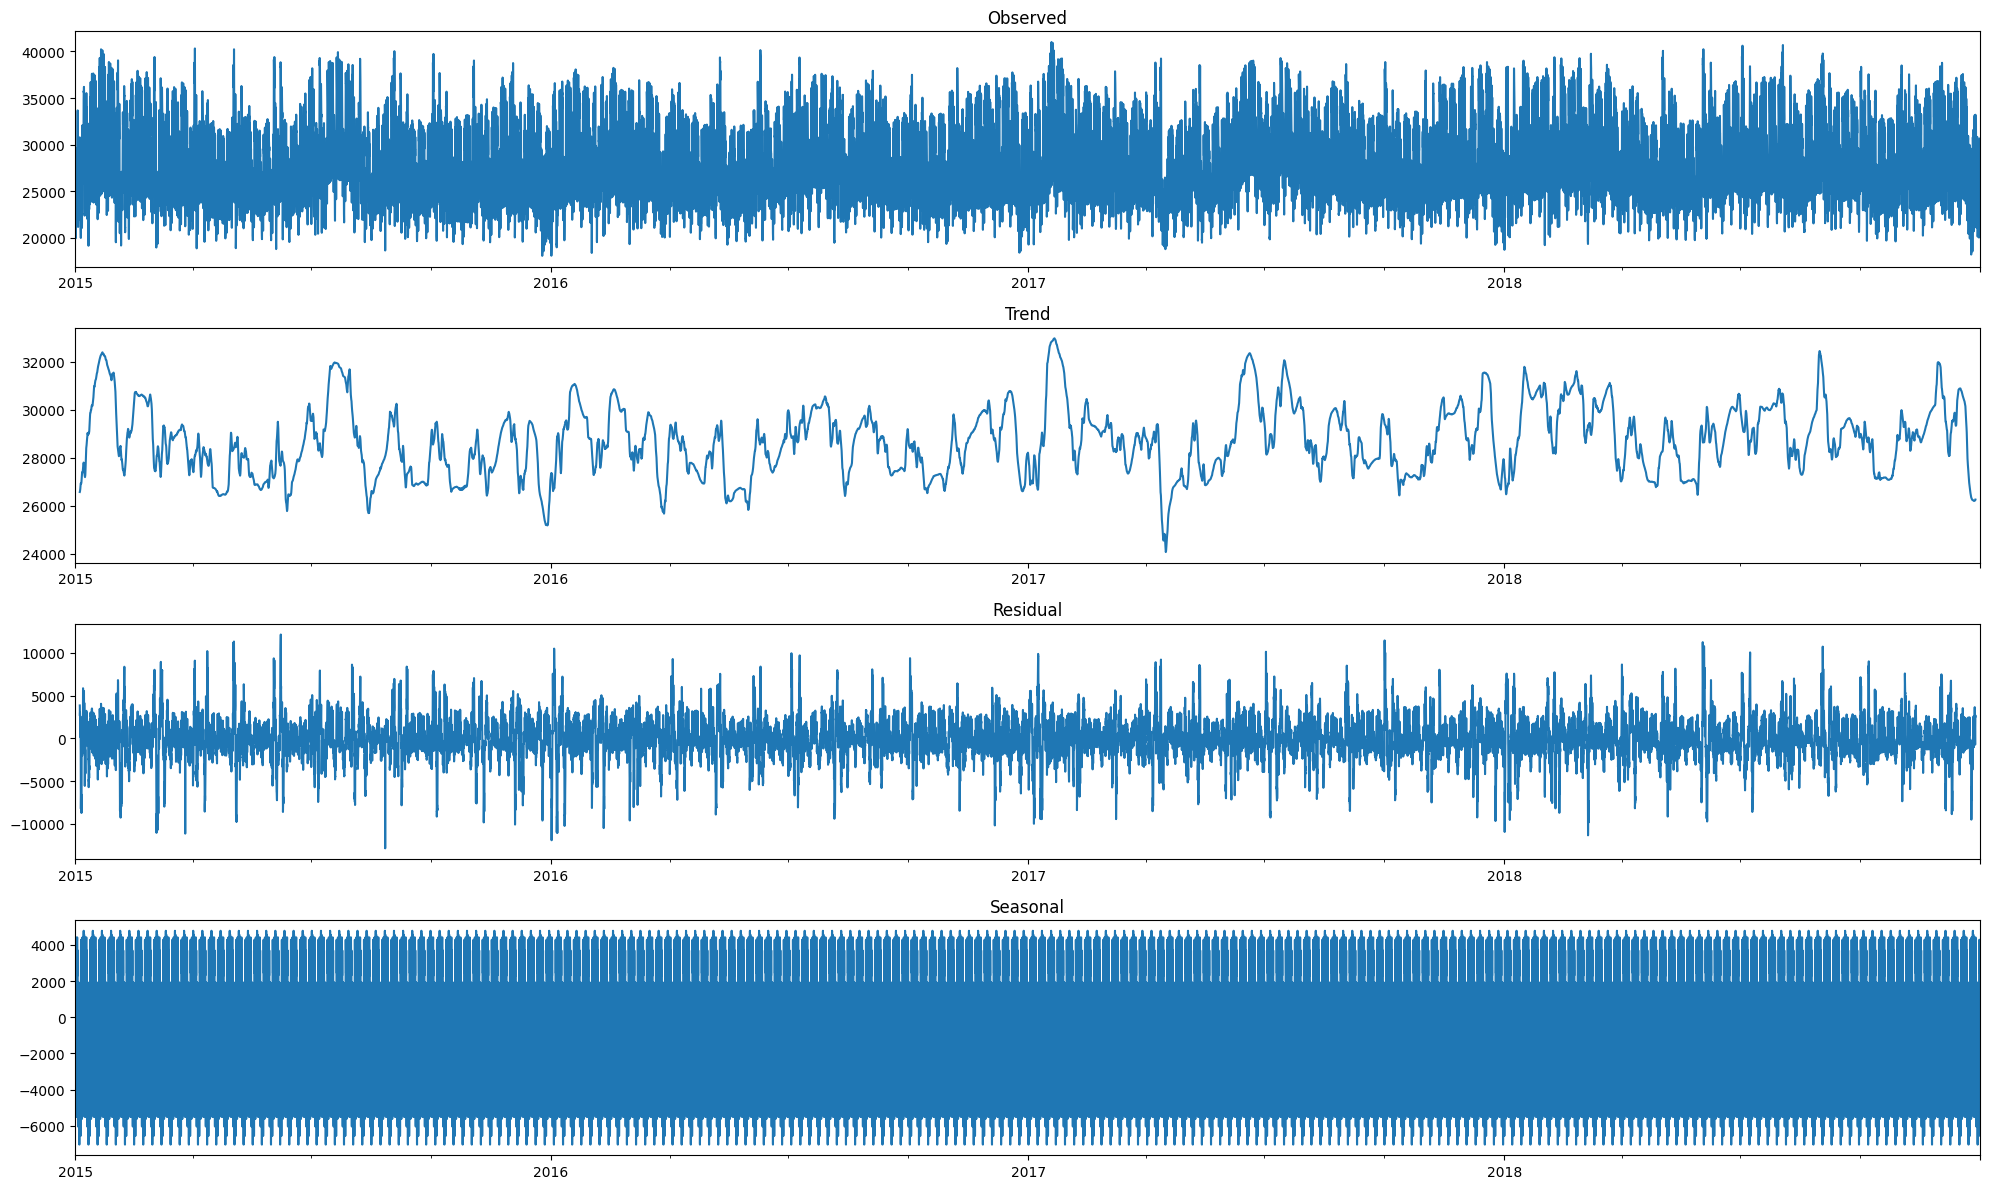

In [14]:
decompose_result = sm.tsa.seasonal_decompose(data[feature], model='additive', period=24*7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
decompose_result.observed.plot(ax=ax1, title='Observed')
decompose_result.trend.plot(ax=ax2, title='Trend')
decompose_result.resid.plot(ax=ax3, title='Residual')
decompose_result.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

## ARIMA

In [ ]:
y = data[feature]
y = y.asfreq('H')
train_size = int(len(y)*0.8)
train, test = y[:train_size], y[train_size:]

/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_83970/3981094326.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = y.asfreq('H')


In [36]:
train = train.asfreq("h")

model = ARIMA(
    train,
    order=(3,1,0),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='t'
)

model_fit = model.fit(
    method="statespace",
    method_kwargs={"method": "powell", "maxiter": 30}
)

print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                  total load actual   No. Observations:                28051
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 24)   Log Likelihood             -223701.269
Date:                            Mon, 01 Dec 2025   AIC                         447416.538
Time:                                    19:56:37   BIC                         447474.224
Sample:                                01-01-2015   HQIC                        447435.108
                                     - 03-14-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.3098    200.905      0.016      0.987    -390.458     397.077
ar.L1          0.4001      0.002   

In [1]:
# auto_model = pm.auto_arima(
#     train,
#     seasonal=True,
#     m=24,

#     stepwise=True,          # MUST BE TRUE (fast)
#     trace=True,
#     suppress_warnings=True,
#     error_action='ignore',

#     max_p=4,
#     max_q=4,
#     max_P=1,               # keep seasonal small
#     max_Q=1,

#     max_d=2,
#     max_D=1
# )

# print(auto_model.summary())


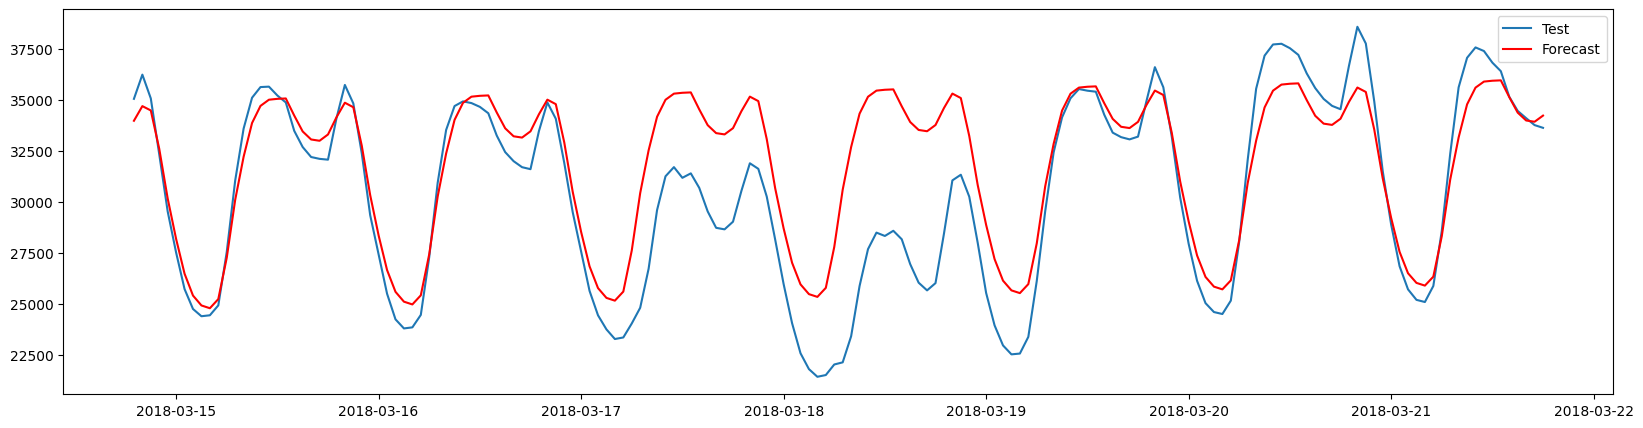

Mean Squared Error: 644728015.1193


In [37]:
# forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
forecast = model_fit.forecast(steps=len(test))
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test[:n_steps], label='Test')
plt.plot(test.index[:n_steps], forecast[:n_steps], label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

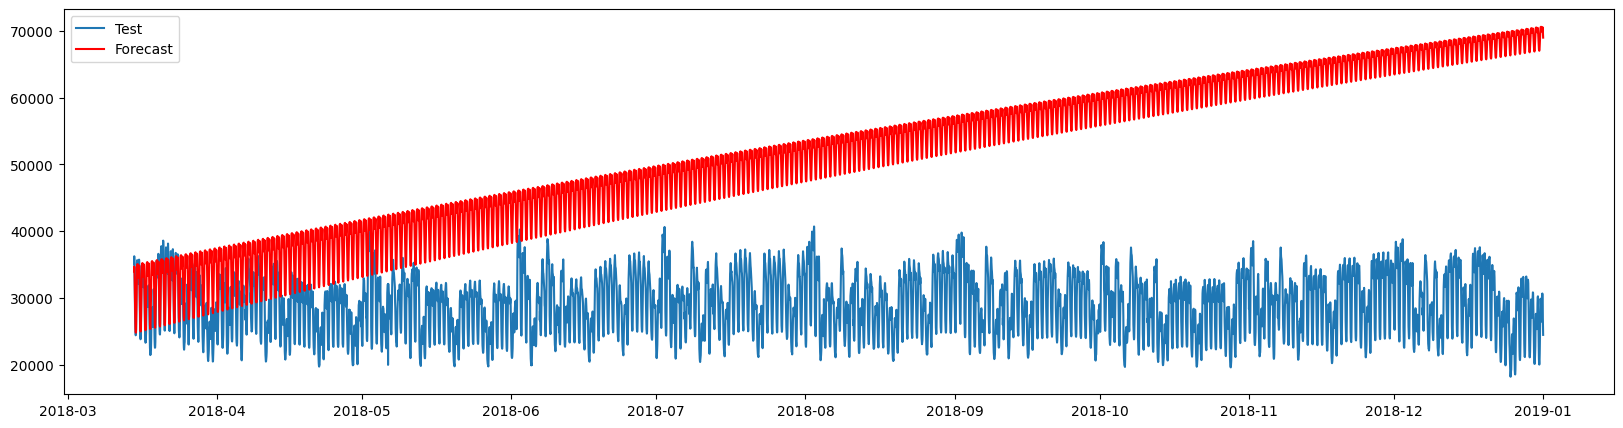

Mean Squared Error: 644728015.1193


In [38]:
# forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
forecast = model_fit.forecast(steps=len(test))
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")


---

## Get exogenous features

In [29]:
data['hour'] = data.index.hour

In [30]:
data['peak_hour'] = 0

data.loc[((data['hour'] >= 8) & (data['hour'] <= 14)) |((data['hour'] >= 18) & (data['hour'] <= 21)),'peak_hour'] = 2

data.loc[(data['hour'] >= 15) & (data['hour'] <= 17),'peak_hour'] = 1

In [113]:
data['hour_sin'] = np.sin(2*np.pi*data.index.hour / 24)
data['hour_cos'] = np.cos(2*np.pi*data.index.hour / 24)
data['week_sin'] = np.sin(2*np.pi*data.index.dayofweek/7)
data['week_cos'] = np.cos(2*np.pi*data.index.dayofweek/7)

data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)

In [139]:
data['total load 1-day lag']  = data['total load actual'].shift(24)
data['total load 1-week lag'] = data['total load actual'].shift(168)


data['total load 1-week lag'] = data['total load 1-day lag'].fillna(data['total load 1-day lag'])
data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-week lag'].mean())

data['total load 1-day lag'] = data['total load 1-day lag'].fillna(data['total load 1-day lag'].mean())

In [140]:
data['avg_temp'] = np.mean(data[['temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia']], axis=1)

In [141]:
X_col = [col for col in data.columns if ('forecast' not in col) and ('generation' not in col) and (col != 'total load actual')]

In [150]:
corr = data[X_col].corrwith(data['total load actual'])

corr_sorted = corr.abs().sort_values(ascending=False)

feature_selected = corr_sorted[:12].index.tolist()
feature_selected.remove('hour')
# feature_selected.remove('temp_Valencia')
feature_selected.append('week_cos')
feature_selected.append('week_sin')


In [151]:
feature_selected

['total load 1-week lag',
 'total load 1-day lag',
 'peak_hour',
 'hour_cos',
 'hour_sin',
 'humidity_Valencia',
 'humidity_Barcelona',
 'humidity_Seville',
 'humidity_Bilbao',
 'is_weekend',
 'temp_min_Valencia',
 'week_cos',
 'week_sin']

In [152]:
X = data[feature_selected]

In [153]:
y = data[feature]
y = y.asfreq('h')
train_size = int(len(y)*0.8)
train, test = y[:train_size], y[train_size:]
Xtrain, Xtest = X[:train_size], X[train_size:]

In [154]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest  = scaler.transform(Xtest)

In [155]:
model = SARIMAX(
    train,
    exog=Xtrain,
    order=(1,1,1),
    seasonal_order=(1,0,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n',
    freq='h'
)

model_fit = model.fit(method="lbfgs", maxiter=50)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   total load actual   No. Observations:                28051
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 24)   Log Likelihood             -225885.064
Date:                             Tue, 02 Dec 2025   AIC                         451804.128
Time:                                     00:37:53   BIC                         451944.223
Sample:                                 01-01-2015   HQIC                        451849.226
                                      - 03-14-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1597.6660      7.747    206.239      0.000    1582.483    1612.849
x2          1597.6660      7.747    206.239      0.000    1582.483    1612.849
x3            63.4221      5.860     10.823      0.000      51.937      74.908
x4          -642.0797     26.332    -24.384      0.000    -693.689    -590.471
x5          -668.7104     26.526    -25.209      0.000    -720.701    -616.719
x6            22.4406     14.877      1.508      0.131      -6.717      51.598
x7             1.5820      8.897      0.178      0.859     -15.856      19.020
x8            82.2541     12.485      6.588      0.000      57.784     106.724
x9            29.1871     10.781      2.707      0.007       8.056      50.318
x10           38.9572     13.535      2.878      0.004      12.429      65.485
x11         -140.4894     24.196     -5.806      0.000    -187.913     -93.066
x12           21.7825     12.015      1.813      0.070      -1.766      45.331
x13            2.4480     14.393      0.170      0.865     -25.762      30.658
ar.L1          0.2967      0.010     30.040      0.000       0.277       0.316
ma.L1          0.1083      0.010     11.353      0.000       0.090       0.127
ar.S.L24      -0.2002      0.003    -59.560      0.000      -0.207      -0.194
sigma2      5.919e+05   1521.880    388.902      0.000    5.89e+05    5.95e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):           2246703.47
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+17. Standard errors may be unstable.
"""

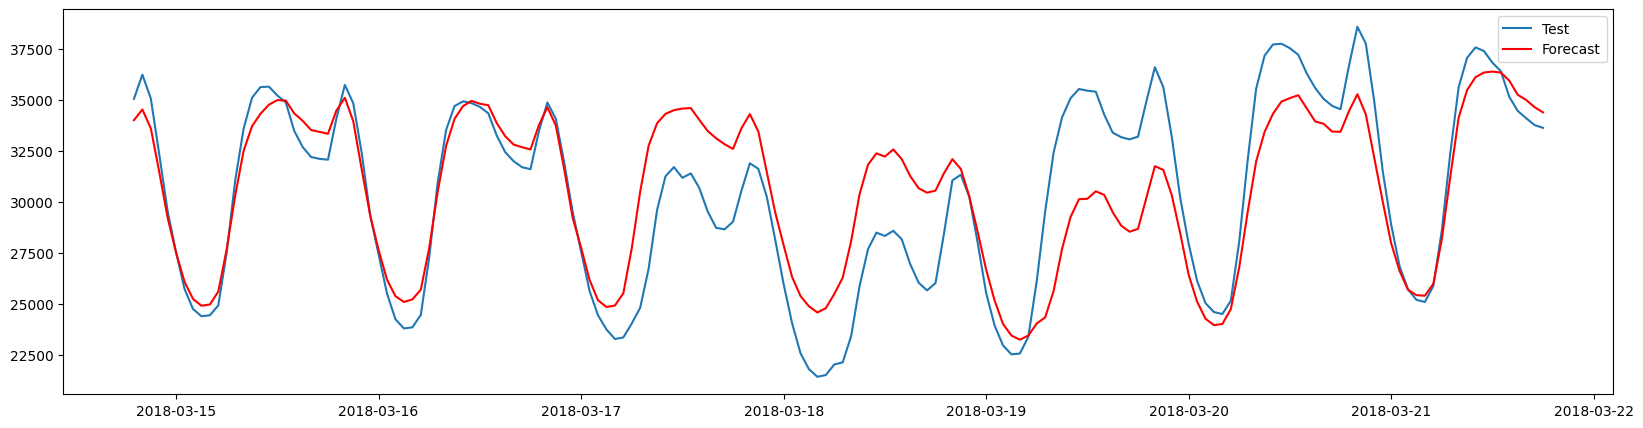

Mean Squared Error: 10027664.8975


In [161]:
forecast = model_fit.get_forecast(steps=len(test), exog=Xtest)
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test[:n_steps], label='Test')
plt.plot(test.index[:n_steps], forecast.predicted_mean[:n_steps], label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast.predicted_mean)
print(f"Mean Squared Error: {mse:.4f}")

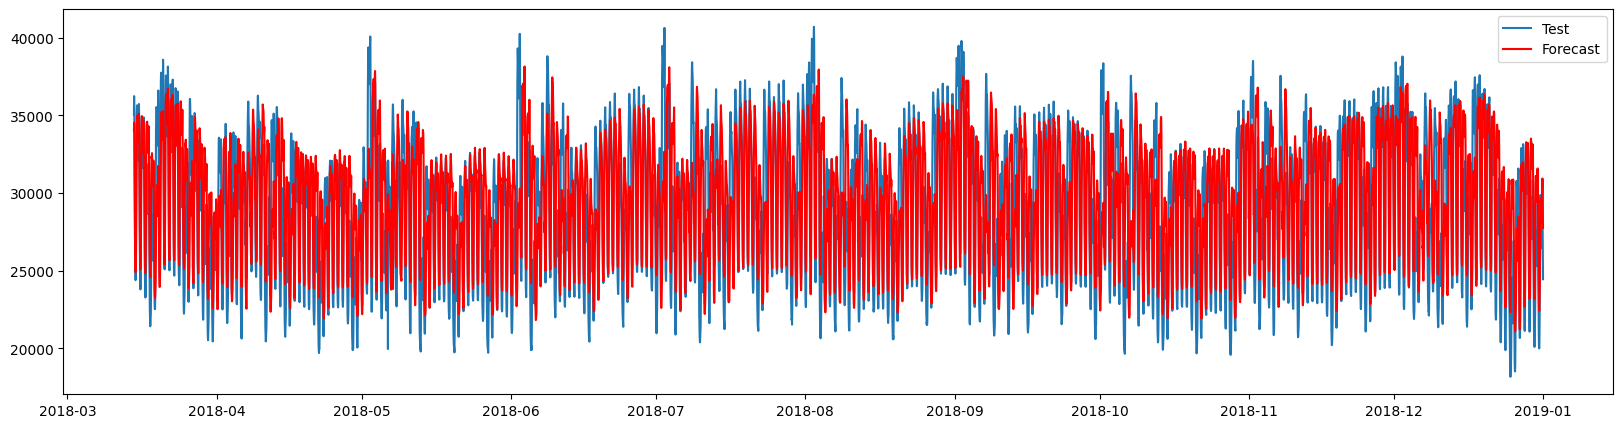

In [159]:
forecast = model_fit.get_forecast(steps=len(test), exog=Xtest)
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast.predicted_mean, label='Forecast', color='red')
plt.legend()
plt.show()


In [163]:
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(test, forecast.predicted_mean)*100))

Testing Mean Absolute Percentage Error: 8.473473083699712


In [132]:
import seaborn as sns

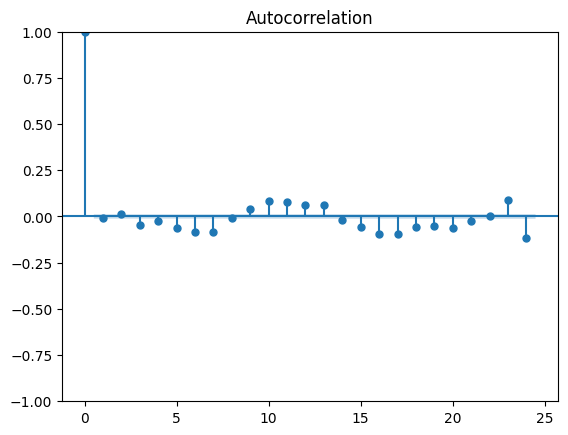

In [138]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(model_fit.resid, lags=24)
plt.show()



## Reload and test trained Model

In [6]:
y = data[feature]
train_percent = 0.8
train_size = 24*7*8
test_size = 24*7*10+1
train, test = y[:train_size], y[train_size:test_size]

In [ ]:
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    stepwise=False,
    suppress_warnings=True,
    trace=True,
    lags=24,
    m=24,
    max_p=4,      
    max_q=4,      
    max_P=2,      
    max_Q=2,      
    # max_d=2,
    # max_D=1
)

print(auto_model.summary())

 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=23679.448, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=22851.788, Time=1.70 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=22679.777, Time=10.23 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=22292.596, Time=1.98 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : AIC=inf, Time=25.46 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=9.78 sec
 ARIMA(0,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=25.72 sec
 ARIMA(0,1,0)(2,0,2)[24] intercept   : AIC=inf, Time=28.33 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=22909.645, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=22393.207, Time=2.70 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=22297.098, Time=15.41 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=22045.435, Time=2.66 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=21787.669, Time=6.35 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=35.32 sec
 ARIMA(0,1

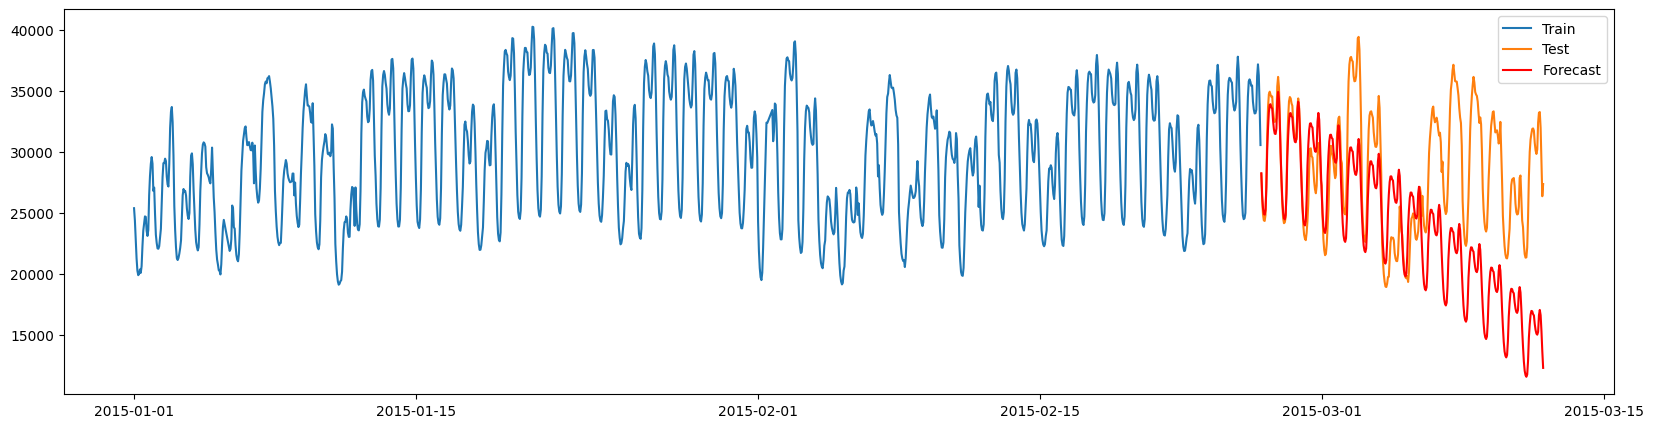

Mean Squared Error: 53811006.2367


In [48]:
import joblib

# model_params = auto_model.get_params()

# joblib.dump(auto_model, "auto_arima_2.pkl")
reloaded_model = joblib.load("auto_arima_2.pkl")
forecast = reloaded_model.predict(n_periods=len(test))

# Plot
plt.figure(figsize=(20,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

In [77]:
reloaded_model.resid()

2015-01-01 00:00:00+01:00    25549.241394
2015-01-01 01:00:00+01:00    -6597.412583
2015-01-01 02:00:00+01:00      260.877987
2015-01-01 03:00:00+01:00       97.757138
2015-01-01 04:00:00+01:00     -417.953902
                                 ...     
2015-02-25 19:00:00+01:00      623.873304
2015-02-25 20:00:00+01:00      -35.645023
2015-02-25 21:00:00+01:00     -478.635975
2015-02-25 22:00:00+01:00     -441.199650
2015-02-25 23:00:00+01:00     -376.105647
Length: 1344, dtype: float64

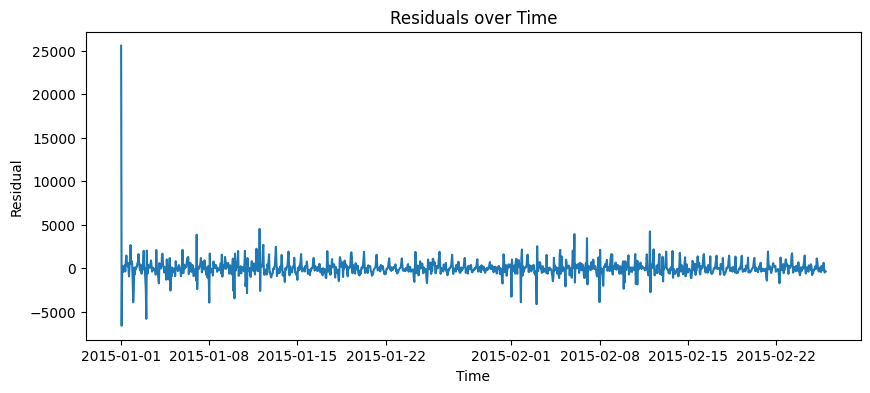

In [78]:
import matplotlib.pyplot as plt

residuals = reloaded_model.resid()  # if you used statsmodels ARIMA/SARIMA

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

In [79]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb)

      lb_stat  lb_pvalue
10  17.650165   0.061159
